In [3]:
import pandas  as pd 
import numpy as np
import matplotlib.pyplot as plt 
import pandas_datareader as web
import datetime as dt 
import yfinance as yf
import pandas_datareader.data as pdr
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [5]:
crypto_currency = 'BNB'
against_currency ='USD'

In [6]:
start = dt.datetime(2021,1,1)
end = dt.datetime.now()-dt.timedelta(days=50)

In [8]:
yf.pdr_override()
data = pdr.get_data_yahoo("BNB-USD", start, end)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-31,38.122288,38.163254,36.744083,37.376034,37.376034,404140896
2021-01-01,37.374573,38.928177,37.046307,37.905010,37.905010,459165743
2021-01-02,37.917107,38.836254,36.925602,38.241592,38.241592,521965394
2021-01-03,38.253727,41.606323,37.818104,41.148979,41.148979,758008613
2021-01-04,41.198280,43.132122,38.143982,40.926353,40.926353,807877171
...,...,...,...,...,...,...
2021-05-13,592.954590,632.970703,530.238220,571.434509,571.434509,7417114170
2021-05-14,570.960510,614.485413,567.034729,603.128296,603.128296,3735474448
2021-05-15,602.554382,610.514160,561.168396,563.041687,563.041687,3480395174


In [48]:
def difference(data, interval=1):
	return [data[i] - data[i - interval] for i in range(interval, len(data))]
def invert_difference(orig_data, diff_data, interval=1):
	return [diff_data[i-interval] + orig_data[i-interval] for i in range(interval, len(orig_data))]
from scipy.stats import boxcox

In [49]:
final_data = pd.DataFrame()
final_data["Close_Open"] = data['Close']-data['Open']
final_data["High_Low"] = data['High']-data['Low']
final_data['Close'] = data['Close']
final_data.head()

KeyError: 'Close'

In [7]:
# Prepare Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(final_data.values)
# logged_data = np.log10(data['Close'])
# scaled_data, lambda_data = (boxcox(data['Close']))#difference(logged_data).to_numpy()
# new = difference((data['Close'],1)
# scaled_data = pd.Series(scaled_data)
prediction_days = 10
future_days=0
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)-future_days):
    x_train.append(scaled_data[x-prediction_days:x])
    y_train.append(scaled_data[x+future_days,2])
x_train, y_train = np.array(x_train), np.array(y_train)
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
# y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1],1))

In [8]:
# range(prediction_days, len(scaled_data))x_train
x_train.shape

(117, 10, 3)

In [9]:
# custom metric for our model, only to monitor our model while training
from tensorflow.keras import backend
 
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [10]:
#creating neural netowrk
model = Sequential()                # could make units 50, for better prediction
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2]) ))
# model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
# model.add(Dropout(0.2))

model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error',metrics=[rmse])
model.fit(x_train,y_train, epochs=400, batch_size=32)

19 - rmse: 0.0293
Epoch 195/400
4/4 [==============================] - 1s 322ms/step - loss: 0.0018 - rmse: 0.0269
Epoch 196/400
4/4 [==============================] - 1s 318ms/step - loss: 0.0016 - rmse: 0.0286
Epoch 197/400
4/4 [==============================] - 1s 317ms/step - loss: 0.0016 - rmse: 0.0266
Epoch 198/400
4/4 [==============================] - 1s 317ms/step - loss: 0.0018 - rmse: 0.0296
Epoch 199/400
4/4 [==============================] - 1s 314ms/step - loss: 0.0016 - rmse: 0.0270
Epoch 200/400
4/4 [==============================] - 1s 320ms/step - loss: 0.0018 - rmse: 0.0307
Epoch 201/400
4/4 [==============================] - 1s 327ms/step - loss: 0.0024 - rmse: 0.0317
Epoch 202/400
4/4 [==============================] - 1s 329ms/step - loss: 0.0018 - rmse: 0.0298
Epoch 203/400
4/4 [==============================] - 2s 491ms/step - loss: 0.0019 - rmse: 0.0308
Epoch 204/400
4/4 [==============================] - 1s 317ms/step - loss: 0.0017 - rmse: 0.0276
Epoch 205/40

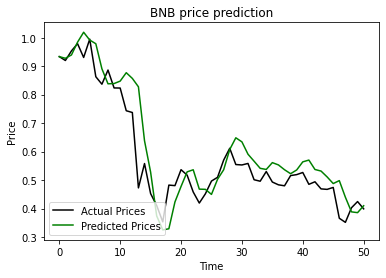

In [11]:
test_start = dt.datetime.now()-dt.timedelta(days=50)
test_end = dt.datetime.now()

test_data = web.DataReader(f'{crypto_currency}-{against_currency}','yahoo', test_start, test_end)

final_test = pd.DataFrame()
final_test['Close_Open'] = test_data['Close'] - test_data['Open']
final_test['High_Low'] = test_data['High'] - test_data['Low']
final_test['Close'] = test_data['Close']

total_dataset = pd.concat((final_data,final_test),axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data)-prediction_days:]
# model_inputs=difference(np.log10((model_inputs))).to_numpy()
# model_inputs = model_inputs
model_inputs = scaler.transform(model_inputs)
actual_prices = (model_inputs[prediction_days:,2])#difference(np.log10((test_data['Close']))).to_numpy()



x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x])
x_test = np.array(x_test)
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

prediction_prices = model.predict(x_test)
# prediction_prices = scaler.inverse_transform(prediction_prices)
# prediction_prices = scaler.inverse_transform(prediction_prices) 
plt.plot(actual_prices,color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='lower left')
plt.show()

4/4 [==============================] - 0s 101ms/step - loss: 0.0013 - rmse: 0.0255


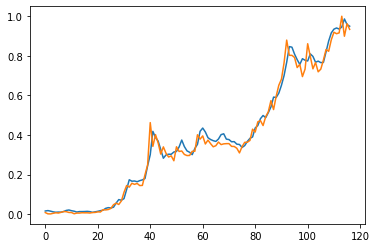

In [13]:
# # Predict Next Day
# real_data = [model_inputs[len(model_inputs) +1 - prediction_days: len(model_inputs) + 1,0]]
# real_data = np.reshape(real_data,-1)
# real_data = np.reshape(real_data, (real_data.shape))
# prediction = model.predict(real_data)
# prediction = scaler.inverse_transform(prediction)
# print()
# (prediction_prices)
# plottiong training dataset  
model.evaluate(x_test,actual_prices)
model.evaluate(x_train,y_train)
plt.plot(model.predict(x_train))
plt.plot(y_train)

In [17]:
re = data['Close']).reshape(-1,1)
data2 = scaler.fit_transform(re)
# data2[3:]
plt.plot(difference(np.log10((data2))).to_numpy(),color='black', label='Actual Prices')

SyntaxError: unmatched ')' (<ipython-input-17-9cbb75c363d4>, line 1)

In [ ]:
pd.Series(np.array(boxcox(data['Close'])))

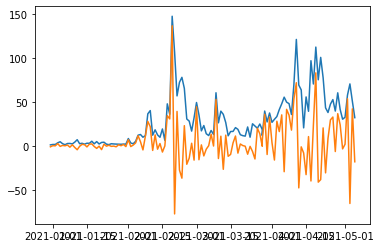

In [197]:
# plt.plot(data['Open'])
# plt.plot(data['Close'])
plt.plot(data['High'] - data['Low'])
plt.plot(data['Close'] - data['Open'])
# plt.plot(data['Close'] - data['High'])
# plt.plot(data['Close'] - data['Low'])
# plt.plot(data['Low'])

## Bottom Line Notes
for 1000 epochs, model is overfitting, 500 seems fine to me. Might decrease the epochs from 500
Optimizer and loss are alright to i guess.
activation function is next (marked in to-do in github projects)